# Plotting API


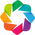

In [1]:
import intake
import numpy as np
import holoviews as hv
from holoviews.operation.datashader import datashade

hv.extension('bokeh')
%output fig='png'

The plotting interface on intake ``DataSource`` objects attempts to mirror the pandas plotting API, but instead of plotting with matplotlib uses HoloViews to generate both static and dynamically streaming bokeh plots. To support plotting streaming data you can use this interface either in a Jupyter notebook or deploy it as a bokeh server app.

For additional information about working and plotting with HoloViews see the [User Guide](http://holoviews.org/user_guide/index.html), as we will focus on using the high-level plotting API in this overview and skip most of the mechanics going on behind the scenes.

We will be focusing on three different datasets:

- A small CSV file of US State level crime data
- A parquet file of airline data
- A streaming data source of packet capture data

In [2]:
crime_source = intake.cat.us_crime
airline_source = intake.cat.airline_flights

## The plot interface

The ``DataSource.plot`` interface provides a powerful high-level API to generate complex plots. The ``.plot`` API can be called directly or used as a namespace to generate specific plot types.

### The plot method

The simplest way to use the plotting API is to specify the names of columns to plot on the ``x``- and ``y``-axis respectively:

:Curve   [Year]   (Violent Crime rate)
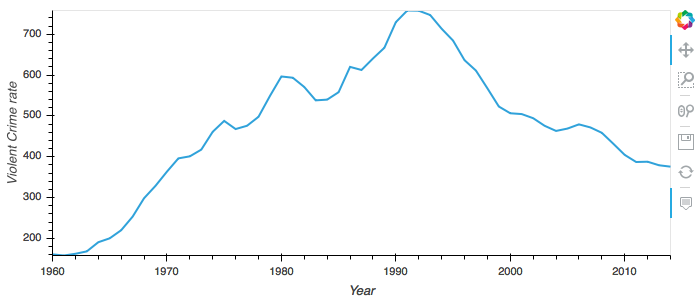

In [3]:
crime_source.plot(x='Year', y='Violent Crime rate')

An additional convenience on top of this explicit API is to specify an additional ``by`` variable, which groups the data by one or more additional columns. As an example here we will plot the departure delay ('depdelay') as a function of 'distance' and group the data by the 'carrier' (and then select just a subset of carriers):

:NdOverlay   [carrier]
   :Scatter   [distance]   (depdelay)
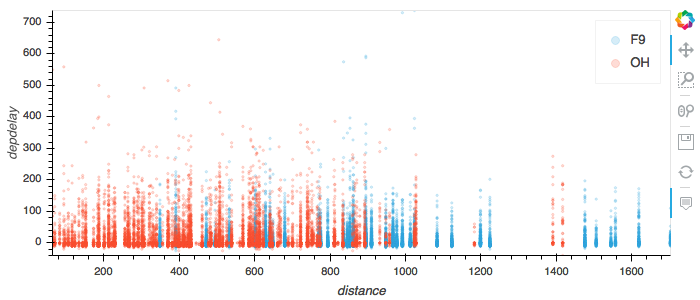

In [4]:
airline_source.plot('distance', 'depdelay', by='carrier', kind='scatter', alpha=0.2).select(carrier=[b'OH', b'F9'])

This approach differs slightly from the usual pandas plotting API, which usually assumes that the dataframe has a meaningful index and the columns represent similar observations. We can reproduce this functionality by enabling the ``use_index`` option and declaring the columns to plot (by default it will use all columns). The ``use_index`` can either be set to ``True`` in which case it will use the actual index or reference a column in which case it will be treated like the index. In this approach the y-axis will receive a default label named 'value' however we can already override the label using the ``value_label`` option.

Putting all of this together we will plot the violent crime, robbery and burglary rates, treating the 'Year' as the index and relabel the y-axis to display the 'Rate'.

:NdOverlay   [Element]
   :Curve   [Year]   (Rate (per 100k people))
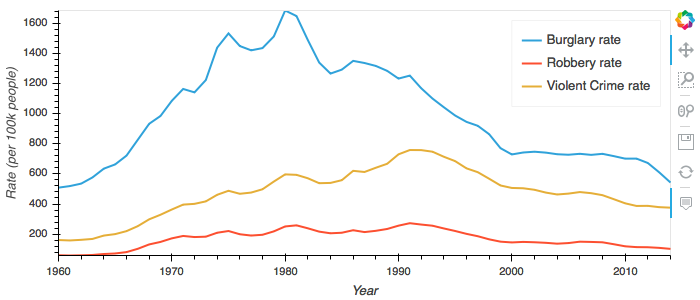

In [5]:
crime_source.plot(use_index='Year', columns=['Violent Crime rate', 'Robbery rate', 'Burglary rate'],
                  value_label='Rate (per 100k people)')

### The plot namespace

Instead of using the ``kind`` argument to the plot call, we can also use the ``plot`` namespace, which lets us easily discover the range of plot types that are supported including:

* <a href="#Area">``area``</a>: Plots a  area chart similar to a line chart except the area under the curve and allows stacking 
* <a href="#Bars">``bar``</a>: Plots a bar chart which can be stacked or grouped
* <a href="#Box-Whisker-Plots">``box``</a>: Plots a box-whisker chart comparing the distribution of one or more variables
* <a href="#HeatMap">``heatmap``</a>: Plots a heatmap to visualizing a variable across two independent dimensions
* <a href="#Histogram">``histogram``</a>: Plots the distribution of one or histograms as a set of bins
* <a href="#KDE">``kde``</a>: Plots the kernel density estimate of one or more variables.
* <a href="#The-plot-method">``line``</a>: Plots a line chart most commonly used for timeseries
* <a href="#Scatter">``scatter``</a>: Plots a scatter chart comparing two variables
* <a href="#Tables">``table``</a>: Generates a SlickGrid DataTable
* <a href="#Violin-Plots">``violin``</a>: Plots a violin plot comparing the distribution of one or more variables by plotting the kernel density estimate

#### Area

Like most other plot types the ``area`` chart supports the three ways of defining a plot outlined above. An area chart is most useful when plotting multiple variables in a stacked chart. This can be achieve by specifying ``x``, ``y`` and ``by`` columns or using the ``use_index`` and ``columns`` options:

:NdOverlay   [Element]
   :Area   [Year]   (value,Baseline)
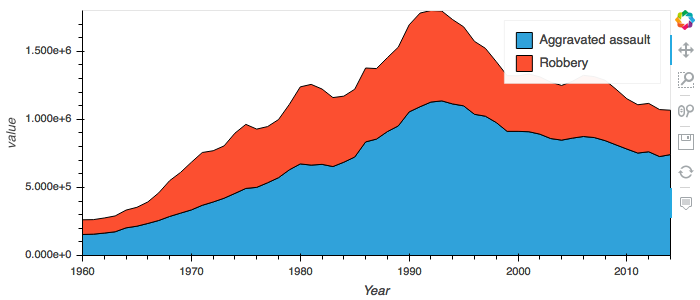

In [6]:
crime_source.plot.area(use_index='Year', columns=['Robbery', 'Aggravated assault'], stacked=True)

We can also explicitly set ``stacked`` to False and define an ``alpha`` value to compare the values directly:

:NdOverlay   [Element]
   :Area   [Year]   (value)
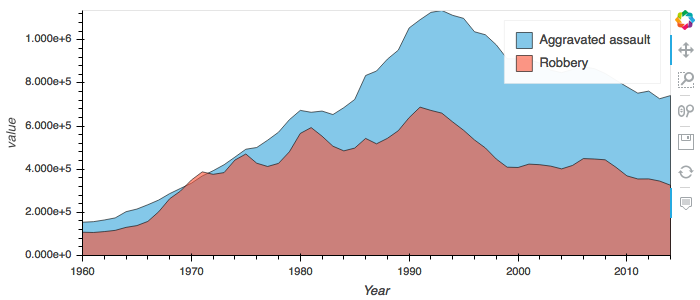

In [7]:
crime_source.plot.area(use_index='Year', columns=['Robbery', 'Aggravated assault'], stacked=False, alpha=0.6)

#### Bars

In the simplest case we can use ``source.plot.bar`` method to plot ``x`` against ``y``:

:Bars   [Year]   (Violent Crime rate)
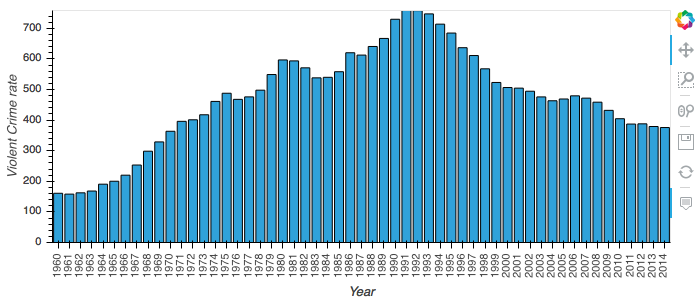

In [8]:
crime_source.plot.bar('Year', 'Violent Crime rate', rot=90)

If we want to compare multiple columns instead we can again use the ``use_index`` option to treat the 'Year' column as the index and then compare the specific columns. Using the ``stacked`` option we can then compare the column values more easily:

:Bars   [Year,Group]   (value)
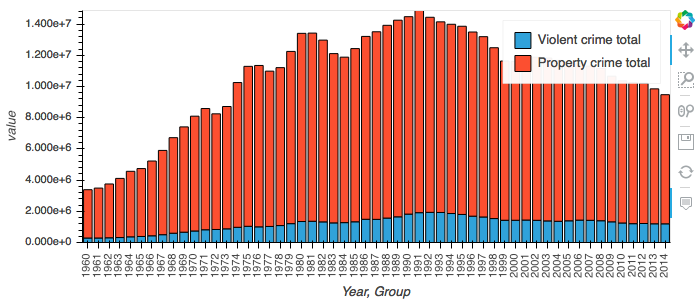

In [9]:
crime_source.plot.bar(use_index='Year', columns=['Violent crime total', 'Property crime total'],
                      stacked=True, rot=90)

#### Scatter

The scatter plot supports all the same features as the other chart types we have seen so far but can also be colored by another variable using the ``c`` option and allows declaring a ``cmap``.

:Scatter   [Violent Crime rate]   (Burglary rate,Year)
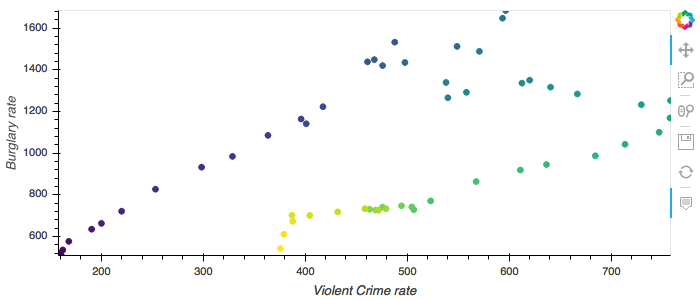

In [10]:
crime_source.plot.scatter('Violent Crime rate', 'Burglary rate', c='Year', cmap='viridis', size=6)

#### HeatMap

A ``HeatMap`` on the other hand lets us view the relationship between three variables so we specify the 'x' and 'y' variables and an additional 'C' variable. Additionally we can define a ``reduce_function`` which computes the values in each bin. Here we plot the 'depdelay' (i.e. departure delay) for each day of the month and carrier in the dataset:

:HeatMap   [day,carrier]   (depdelay)
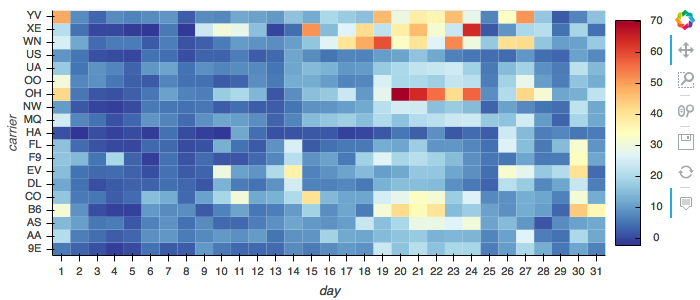

In [11]:
airline_source.plot.heatmap(x='day', y='carrier', C='depdelay', reduce_function=np.mean,
                            colorbar=True, use_dask=False).sort()

#### Tables

Unlike all other plot types a table only supports one signature, either all columns are plotted or a subset of columns can be selected by defining the ``columns`` explicitly:

:Table   [Year,Population,Violent Crime rate]
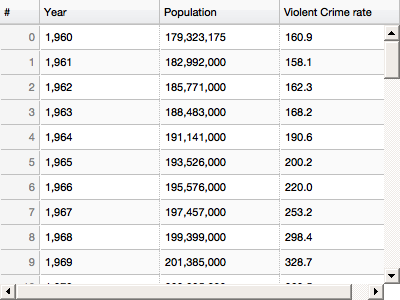

In [12]:
crime_source.plot.table(columns=['Year', 'Population', 'Violent Crime rate'], width=400)

### Distributions

Plotting distributions differs slightly from other plots since they plot only one variable in the simple case rather than plotting two or more variables against each other. Therefore when plotting these plot types no ``index`` or ``x`` value needs to be supplied:

1. Declare a single ``y`` variable, e.g. ``source.plot.hist(variable)``
2. Declare a ``y`` variable and ``by`` variable, e.g. ``source.plot.hist(variable, by='Group')``
3. Declare columns or plot all columns, e.g. ``source.plot.hist()`` or ``source.plot.hist(columns=['A', 'B', 'C'])``

#### Histogram

The Histogram is the simplest example of this, often we simply plot the distribution of a single variable, in this case the 'Violent Crime rate'. Additionally we can define a range over which to compute the histogram and the number of bins using the ``bin_range`` and ``bins`` arguments respectively:

:Histogram   [Violent Crime rate]   (Violent Crime rate_frequency)
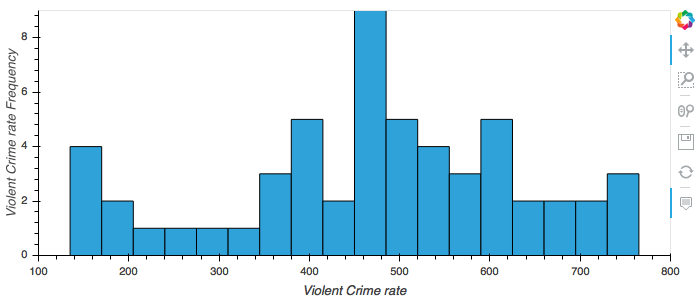

In [13]:
crime_source.plot.hist('Violent Crime rate', bin_range=(100, 800), bins=20)

Alternatively we can plot the distribution of multiple columns:

:NdOverlay   [Element]
   :Histogram   [Violent Crime rate]   (Violent Crime rate_frequency)
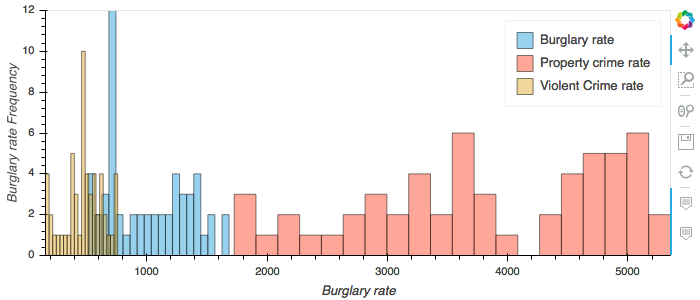

In [14]:
columns=['Violent Crime rate', 'Property crime rate', 'Burglary rate']
crime_source.plot.hist(columns=columns, bins=20, alpha=0.5)

Finally we can also group the data by another variable:

:NdOverlay   [carrier]
   :Histogram   [depdelay]   (depdelay_frequency)
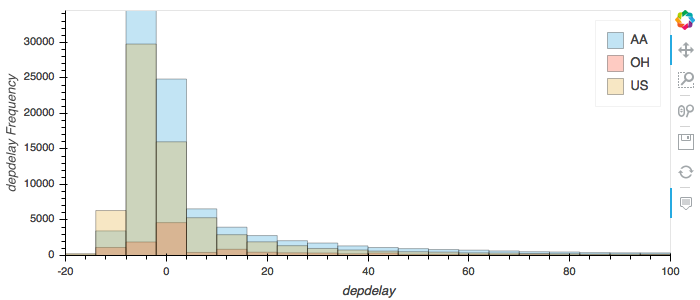

In [15]:
airline_source.plot.hist('depdelay', by='carrier', bins=20, bin_range=(-20, 100), alpha=0.3).\
  select(carrier=[b'AA', b'US', b'OH'])

#### KDE

You can also create density plots using ``DataSource.plot.kde()`` method:

:Distribution   [Violent Crime rate]   (Density)
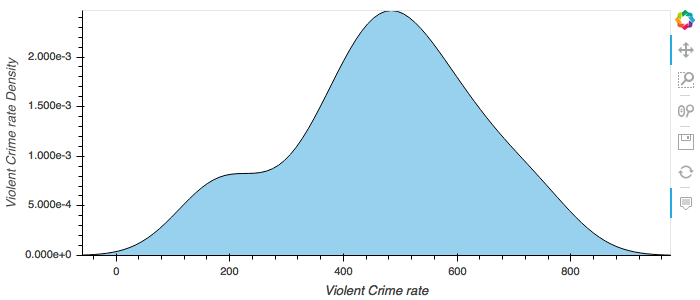

In [16]:
crime_source.plot.kde('Violent Crime rate')

Comparing the distribution of multiple columns is also possible:

:NdOverlay   [Group]
   :Distribution   [Rate]   (Density)
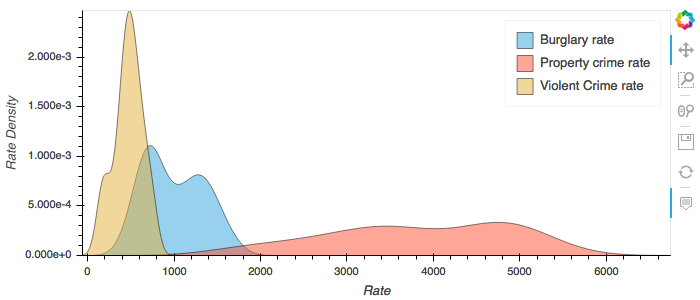

In [17]:
columns=['Violent Crime rate', 'Property crime rate', 'Burglary rate']
crime_source.plot.kde(columns=columns, bins=20, alpha=0.5, value_label='Rate')

The ``DataSource.plot.kde`` also supports the ``by`` keyword:

:NdOverlay   [carrier]
   :Distribution   [depdelay]   (Density)
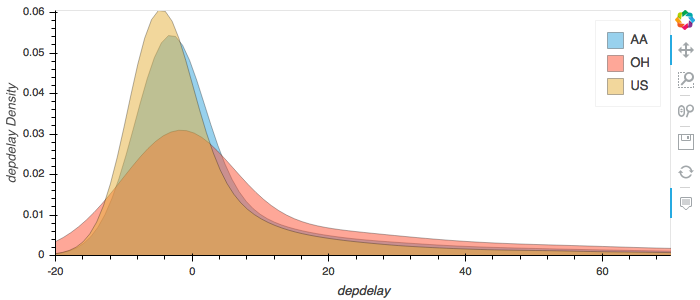

In [18]:
airline_source.plot.kde('depdelay', by='carrier', alpha=0.3)\
   .select(carrier=[b'AA', b'US', b'OH']).redim.range(depdelay=(-20, 70))

#### Box-Whisker Plots

Just like the other distribution based plot types the box-whisker plot supports plotting a single column:

:BoxWhisker   (Violent Crime rate)
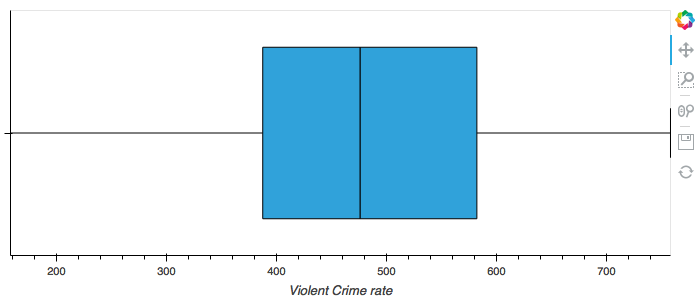

In [19]:
crime_source.plot.box('Violent Crime rate', vert=True)

It also supports multiple columns:

:BoxWhisker   [Crime]   (Rate (per 100k))
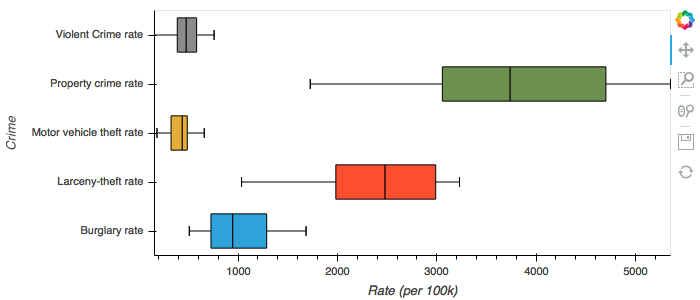

In [20]:
columns=['Burglary rate', 'Larceny-theft rate', 'Motor vehicle theft rate',
         'Property crime rate', 'Violent Crime rate']
crime_source.plot.box(columns=columns, group_label='Crime', legend=False, value_label='Rate (per 100k)', vert=True)

Lastly, it also supports using the ``by`` keyword to split the data into multiple subsets:

:BoxWhisker   [carrier]   (depdelay)
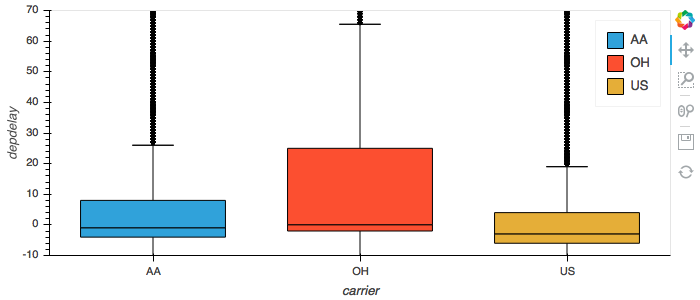

In [21]:
airline_source.plot.box('depdelay', by='carrier')\
   .select(carrier=[b'AA', b'US', b'OH']).redim.range(depdelay=(-10, 70))

## Composing Plots

One of the core strengths of HoloViews is the ease of composing
different plots. Individual plots can be composed using the ``*`` and
``+`` operators, which overlay and compose plots into layouts
respectively. For more information on composing objects see the
HoloViews [User Guide](http://holoviews.org/user_guide/Composing_Elements.html).

By using these operators we can combine multiple plots into composite plots, a simple example is overlaying two plot types:

:Overlay
   .Curve.I   :Curve   [Year]   (Violent Crime rate)
   .Scatter.I :Scatter   [Year]   (Violent Crime rate)
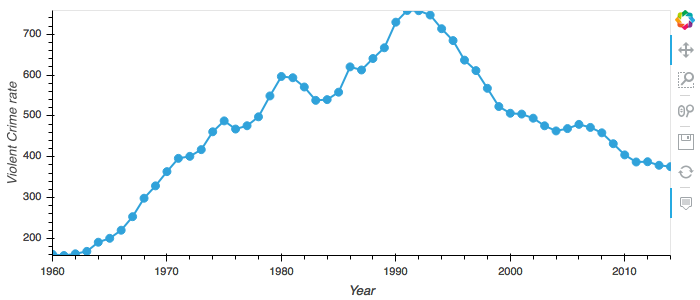

In [22]:
crime_source.plot('Year', 'Violent Crime rate') * crime_source.plot.scatter('Year', 'Violent Crime rate', size=8)

We can also lay out different plots and tables together:

:Layout
   .Bars.I  :Bars   [Year]   (Violent Crime rate)
   .Table.I :Table   [Year,Population,Violent Crime rate]
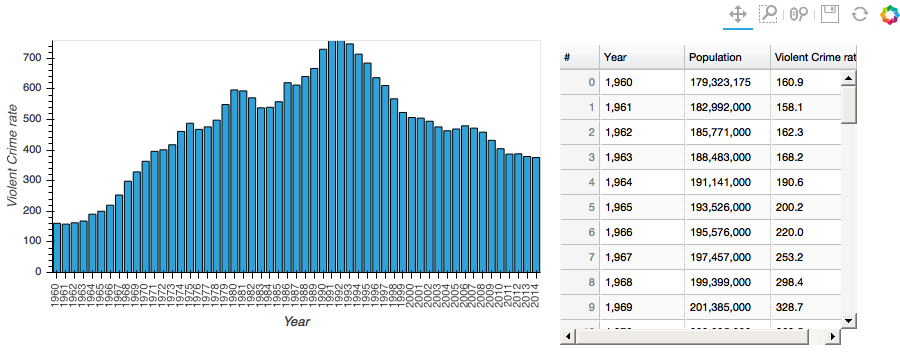

In [23]:
(crime_source.plot.bar('Year', 'Violent Crime rate', rot=90, width=550) +
 crime_source.plot.table(['Year', 'Population', 'Violent Crime rate'], width=350))

## Large data

The previous examples summarized the fairly large airline dataset using statistical plot types, however if we do not want to summarize the data and view all of the raw data at once we will have to use datashader to generate a fixed size image of the data. Here we plot the 'airtime' against the 'distance':

In [29]:
3**6 * 2

1458

In [ ]:
W W
W L
W D
D W


In [27]:
3**13 * 0.2

318864.60000000003

:DynamicMap   []
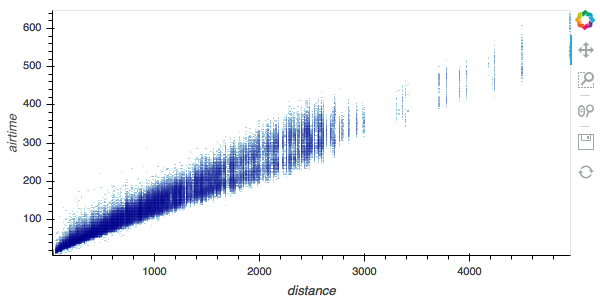

In [25]:
datashade(airline_source.plot.scatter('distance', 'airtime')).options(width=600)

## Customizing the visualization

In addition to specific options for different plot types the plotting
API exposes a number of general options including:

- ``grid`` (default=False): Whether to show a grid
- ``hover`` (default=True): Whether to show hover tooltips
- ``legend`` (default=True): Whether to show a legend
- ``logx``/``logy`` (default=False): Enables logarithmic x- and y-axis respectively
- ``shared_axes`` (default=False): Whether to link axes between plots
- ``title`` (default=''): Title for the plot
- ``xlim``/``ylim`` (default=None): Plot limits of the x- and y-axis
- ``xticks``/``yticks`` (default=None): Ticks along x- and y-axis specified as an integer, list of ticks postions, or list of tuples of the tick positions and labels
- ``width`` (default=800)/``height`` (default=300): The width and height of the plot in pixels

In addition, options can be passed directly to HoloViews providing
greater control over the plots. The options can be provided as
dictionaries via the ``plot_opts`` and ``style_opts`` keyword
arguments. You can also apply options using the HoloViews API (for
more information see the HoloViews [User Guide](http://holoviews.org/user_guide/Customizing_Plots.html).
